<a href="https://colab.research.google.com/github/chazycharles/Image-Recognition/blob/main/ChatVSChien.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Ce projet a pour but de développer un réseau de neurones basé sur numpy afin de pouvoir classer les images étiquetées selon leur classe.
J'ai développé un réseau de neurones à 2 couches avec descendant de gradient comme fonction d'activation et perte d'entropie croisée pour suivre les performances du modèle. 
Dans la première expiration, nous utilisons les pixels standard des images en entrée, nous remodelons l'image puis l'aplatissons. Dans la deuxième expiration, nous introduisons la notion "d'Histogramme de Gradients Orientés" pour l'utiliser comme entrée de notre réseau.

In [ ]:
! pip install h5py

In [ ]:
import numpy as np
import h5py
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.metrics import log_loss

In [ ]:
def load_data():
    train_dataset = h5py.File('trainset.hdf5', "r")
    X_train = np.array(train_dataset["X_train"][:]) # your train set features
    y_train = np.array(train_dataset["Y_train"][:]) # your train set labels

    test_dataset = h5py.File('testset.hdf5', "r")
    X_test = np.array(test_dataset["X_test"][:]) # your train set features
    y_test = np.array(test_dataset["Y_test"][:]) # your train set labels
    
    return X_train, y_train, X_test, y_test

In [ ]:
X_train, y_train, X_test, y_test = load_data()

In [ ]:
print(X_test.shape)
print(X_train.shape)
print(y_test.shape)
print(y_train.shape)

(200, 64, 64)
(1000, 64, 64)
(200, 1)
(1000, 1)


/usr/local/lib/python3.7/dist-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


<function matplotlib.pyplot.show>

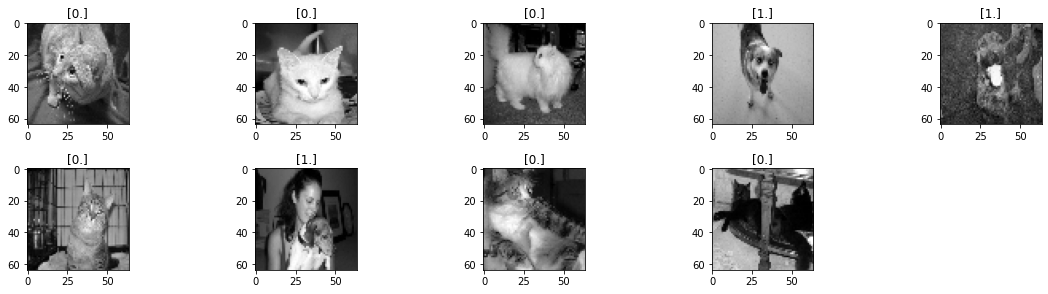

In [ ]:
plt.figure(figsize=(16, 8))
for i in range(1,10):
    plt.subplot(4,5,i)
    plt.imshow(X_train[i], cmap = "gray")
    plt.title(y_train[i])
    plt.tight_layout()
plt.show

In [ ]:
y_train = y_train.T
y_test = y_test.T

X_train = X_train.T
X_train_reshape = X_train.reshape(-1, X_train.shape[-1]) / X_train.max()

X_test = X_test.T
X_test_reshape = X_test.reshape(-1, X_test.shape[-1]) / X_train.max()

print(X_train_reshape.shape)
print(X_test_reshape.shape)
print(y_train.shape)
print(y_test.shape)

(4096, 1000)
(4096, 200)
(1, 1000)
(1, 200)


In [ ]:
def initialisation(n0, n1, n2):
    W1 = np.random.randn(n1, n0)
    b1 = np.random.randn(n1, 1)
    W2 = np.random.randn(n2, n1)
    b2 = np.random.randn(n2, 1)
    
    parameters = {
        'W1':W1,
        'b1':b1,
        'W2':W2,
        'b2':b2 }

    return parameters

In [ ]:
def forward_propagation(X, parameters):
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']

    Z1 = W1.dot(X) + b1
    A1 = 1 / (1 + np.exp(-Z1))

    Z2 = W2.dot(A1) + b2
    A2 = 1 / (1 + np.exp(-Z2))

    activations = {
        'A1':A1,
        'A2':A2 }

    return activations

In [ ]:
def back_propagation(X, y, activations, parameters):
    A1 = activations['A1']
    A2 = activations['A2']
    W2 = parameters['W2']
    m = y.shape[1]

    dZ2 = A2 - y
    dW2 = 1/ m * dZ2.dot(A1.T)
    db2 = 1/ m * np.sum(dZ2, axis = 1, keepdims=True)
    
    dZ1 = np.dot(W2.T,dZ2)*A1*(1-A1)
    dW1 = 1/ m * dZ1.dot(X.T)
    db1 = 1/ m * np.sum(dZ1, axis = 1, keepdims=True)
    
    gradients = {
        'dW2':dW2,
        'db2':db2,
        'dW1':dW1,
        'db1':db1 }

    return gradients

In [ ]:
def update(gradients, parameters, learning_rate):

    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']

    dW1 = gradients['dW1']
    dW2 = gradients['dW2']
    db1 = gradients['db1']
    db2 = gradients['db2']

    W1 = W1 - learning_rate*dW1
    b1 = b1 - learning_rate*db1
    W2 = W2 - learning_rate*dW2
    b2 = b2 - learning_rate*db2

    parameters = {
        'W1':W1,
        'b1':b1,
        'W2':W2,
        'b2':b2 }
  
    return parameters

In [ ]:
def predict(X,parameters):
    activations = forward_propagation(X,parameters)
    A2 = activations['A2']
    
    return A2 >= 0.5

In [ ]:
def network(X_train, y_train, X_test, y_test, n1, learning_rate = 0.1, n = 100):
    n0 = X_train.shape[0]
    n2 = y_train.shape[0]

    parameters = initialisation(n0, n1, n2)
    train_loss = []
    train_acc = []
    test_loss = []
    test_acc = []

    for i in range(n):
        activations = forward_propagation(X_train, parameters)
        gradients = back_propagation(X_train, y_train, activations, parameters)
        parameters = update(gradients, parameters, learning_rate)

        train_loss.append(log_loss(y_train, activations['A2']))
        y_pred = predict(X_train, parameters)
        train_acc.append(accuracy_score(y_train.flatten(), y_pred.flatten()))

        #act = forward_propagation(X_test, parameters)
        #test_loss.append(log_loss(y_test, act['A2']))
        #y_pred = predict(X_test, parameters)
        #test_acc.append(accuracy_score(y_test.flatten(), y_pred.flatten()))
  

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(train_loss, label='train loss')
    #plt.plot(test_loss, label = 'test loss')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(train_acc, label='train acc')
    #plt.plot(test_acc, label = 'test acc')
    plt.legend()
    plt.show()

    return parameters

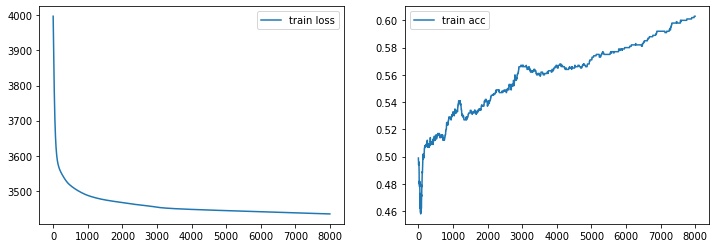

In [ ]:
parameters1 = network(X_train_reshape, y_train, X_test_reshape, y_test, n1 = 32, learning_rate = 0.01, n = 8000)

### Histogram of Oriented Gradients 

In [ ]:
from skimage.feature import hog

In [ ]:
trainX, trainY, testX, testY = load_data()

In [ ]:
trainX[0].shape

(64, 64)

In [ ]:
def hogg(x):
    hogs = np.empty([0, 512])
    for i in range(x.shape[0]):
      fd, hog_image = hog(x[i], orientations=8, pixels_per_cell=(8, 8), cells_per_block=(1, 1), visualize=True, multichannel=False)
      fd = fd.reshape(fd.shape[0], 1).T
      hogs = np.vstack((hogs, fd))
    return hogs

In [ ]:
hogTrain = hogg(trainX)
hogTest = hogg(testX)

hogTrain = hogTrain.T/ hogTrain.max()
hogTest = hogTest.T / hogTrain.max()
trainY = trainY.T
testY = testY.T

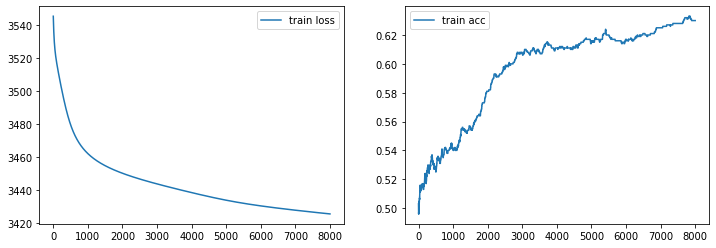

In [ ]:
parameters2 = network(hogTrain, trainY, hogTest, testY, n1 = 32, learning_rate = 0.01, n = 8000)